**SOFT DEADLINE:** `20.03.2022 23:59 msk` 

# [5 points] Part 1. Data cleaning

The task is to clear the text data of the crawled web-pages from different sites. 

It is necessary to ensure that the distribution of the 100 most frequent words includes only meaningful words in english language (not particles, conjunctions, prepositions, numbers, tags, symbols).

Determine the order of operations below and carry out the appropriate cleaning.

1. Remove non-english words
1. Remove html-tags (try to do it with regular expression, or play with beautifulsoap library)
1. Apply lemmatization / stemming
1. Remove stop-words
1. Additional processing - At your own initiative, if this helps to obtain a better distribution

#### Hints

1. To do text processing you may use nltk and re libraries
1. and / or any other libraries on your choise

#### Data reading

The dataset for this part can be downloaded here: `https://drive.google.com/file/d/1wLwo83J-ikCCZY2RAoYx8NghaSaQ-lBA/view?usp=sharing`

In [32]:
import pandas as pd
from bs4 import BeautifulSoup
import html
import re
import nltk
import sys
import spacy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
import string
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
nltk.download('words')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

path = "/content/gdrive/MyDrive/NLP/hw1"

Mounted at /content/gdrive


In [4]:
raw_df = pd.read_csv(f"{path}/web_sites_data.csv")

In [5]:
pages = raw_df['text'].to_list()

#### Data processing

In [6]:
regex = re.compile("[^A-z]+")

In [7]:
def clean(raw_text):
    text = BeautifulSoup(raw_text, "html5lib").get_text()

    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    words = [regex.sub(" ", word.lower()) for word in tokens]

    sw = nltk.corpus.stopwords.words('english')
    words_ns = [word for word in words if word not in sw]
    
    return ' '.join(words_ns)

In [8]:
for item in tqdm(pages[25000:50000]):
    processed = clean(item)
    with open(f'{path}/processed.txt', 'w') as w:
        w.write(processed + '\n')

100%|██████████| 25000/25000 [31:07<00:00, 13.39it/s]


#### Vizualization

As a visualisation, it is necessary to construct a frequency distribution of words (the 100 most common words), sorted by frequency. 

For visualization purposes we advice you to use plotly, but you are free to choose other libraries

In [9]:
%matplotlib inline
sns.set()

In [10]:
with open(f'{path}/processed.txt', 'r', encoding='utf-8') as r:
    data = r.readlines()

In [11]:
text = ' '.join(data)

In [12]:
freqdist1 = nltk.FreqDist(text.split())

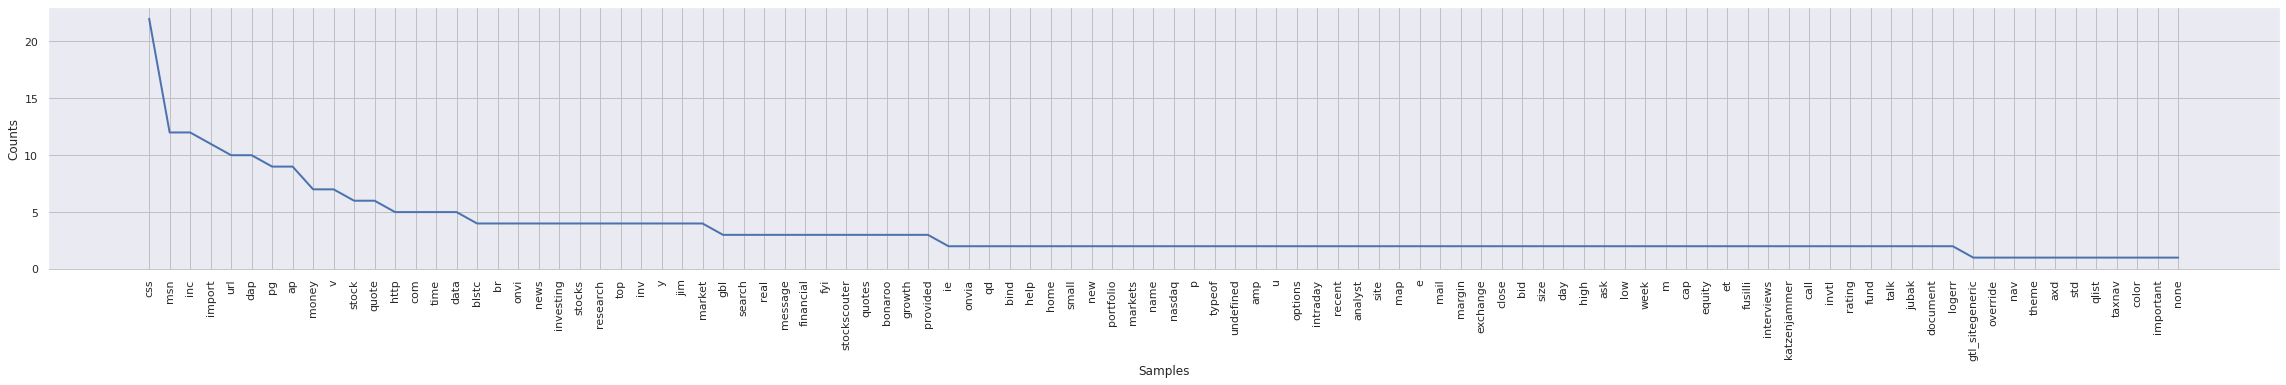

In [13]:
fig = plt.figure(figsize = (40,5))
plt.gcf().subplots_adjust(bottom=0.15)
freqdist1.plot(100, cumulative=False)
plt.show()

#### Provide examples of processed text (some parts)

Is everything all right with the result of cleaning these examples? What kind of information was lost?

In [14]:
# Before
pages[25000][:500]

'\n<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<HTML>\n\t<HEAD>\n\t\t<title>BookFinder4u - King Henry IV: Pt. 2, ISBN: 0001050508, 9780001050501</title>\n\t\t<meta name="Description" content="King Henry IV: Pt. 2, ISBN 0001050508, 9780001050501, Book Finder, Compare Book Prices at 130 book stores">\n\t\t<meta name="Keywords" content="0001050508, King Henry IV: Pt. 2, 9780001050501, book finder, bookfinder4u, compare book prices, book price comparison">\n\t\t<meta content="index,nofollow" nam'

In [15]:
# After
data[0][:500]

'import url http blstc msn com br gbl css   gtl_sitegeneric css import url http blstc msn com br gbl css     css import url http blstc msn com br money css   override css import url inc css nav css v   import url inc css     theme axd import url inc css std css v   import url inc css qlist css v   taxnav color   important import url inc css ie none css v   onvi stock quote onvia inc msn money import inc css qd css v   import url inc css quotectrl css v   import url inc css tabular css v   phid mc'

We can see at the result of cleaning that javascript code was not completely cleaned.

# [10 points] Part 2. Duplicates detection. LSH

#### Libraries you can use

1. LSH - https://github.com/ekzhu/datasketch
1. LSH - https://github.com/mattilyra/LSH
1. Any other library on your choise

1. Detect duplicated text (duplicates do not imply a complete word-to-word match, but texts that may contain a paraphrase, rearrangement of words, sentences)
1. Make a plot dependency of duplicates on shingle size (with fixed minhash length) 
1. Make a plot dependency of duplicates on minhash length (with fixed shingle size)

In [17]:
! pip install datasketch

     |████████████████████████████████| 75 kB 5.1 MB/s 


In [18]:
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt

In [19]:
def shingle(t, ngram=5):
    return set(t[head:head + ngram] for head in range(0, len(t)))

def LSH(data, ngrams, num_perms, threshold):
    
    transformed = [shingle(d, ngrams) for d in data]
    
    min_hashes = []
    for item in transformed:
        minh = MinHash(num_perms)
        [minh.update(d.encode('utf-8')) for d in item]            
        min_hashes.append(minh)

    lsh = MinHashLSH(threshold, num_perms)
    [lsh.insert(id, minh) for id, minh in enumerate(min_hashes)]

    doc_sim = []
    for id, hash in enumerate(min_hashes):
        similar = lsh.query(hash)
        if id in similar:
            similar.remove(id)
        doc_sim.extend(similar)
    
    return set(doc_sim)

In [33]:
def plot_dependency(x, y, xlabel, ylabel, title, opacity=.75):
    trace = go.Bar(
        x = x,
        y = y,
        opacity=opacity
    )

    layout = go.Layout()
    fig = go.Figure(data=[trace], layout=layout)
    fig.update_xaxes(title_text=xlabel)
    fig.update_yaxes(title_text=ylabel)
    fig.update_layout(title=title)
    iplot(fig)

In [ ]:
ngrams = [num for num in range(0, 7, 1)]

# fixed minhash length
fminhash_result = []
for gram in tqdm(ngrams):
    result = LSH(text[:15000], gram, 128, 0.5)
    fminhash_result.append(len(result))

In [34]:
plot_dependency(ngrams, fminhash_result, 'Shingle Size', 'Duplicates', 'Dependency of Duplicates on Shingle Size (with fixed minhash length)')

In [36]:
num_perms = [64, 128, 256, 512, 1024]

# fixed shingles length
fshingle_result = []
for perms in tqdm(num_perms):
    result = LSH(text[:15000], 5, perms, 0.5)
    fshingle_result.append(len(result))

100%|██████████| 5/5 [01:56<00:00, 23.26s/it]


In [37]:
plot_dependency(num_perms, fshingle_result, 'MinHash Size', 'Duplicates', 'Dependency of Duplicates on Minhash Length (with fixed shingle size)')

# [Optional 10 points] Part 3. Topic model

In this part you will learn how to do topic modeling with common tools and assess the resulting quality of the models. 

The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

#### Preprocess dataset with the functions from the Part 1

#### Quality estimation

Implement the following three quality fuctions: `coherence` (or `tf-idf coherence`), `normalized PMI`, `based on the distributed word representation`(you can use pretrained w2v vectors or some other model). You are free to use any libraries (for instance gensim) and components.

### Topic modeling

Read and preprocess the dataset, divide it into train and test parts `sklearn.model_selection.train_test_split`. Test part will be used in classification part. For simplicity we do not perform cross-validation here, but you should remember about it.

Plot the histogram of resulting tokens counts in the processed datasets.

Plot the histogram of resulting tokens counts in the processed datasets.

#### NMF

Implement topic modeling with NMF (you can use `sklearn.decomposition.NMF`) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

#### LDA

Implement topic modeling with LDA (you can use gensim implementation) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

### Additive regularization of topic models 

Implement topic modeling with ARTM. You may use bigartm library (simple installation for linux: pip install bigartm) or TopicNet framework (`https://github.com/machine-intelligence-laboratory/TopicNet`)

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

Write a function to convert new documents to topics probabilities vectors.

Calculate the quality scores for each model. Make a barplot to compare the quality.